In [1]:
# Install libraries
#install.packages("pROC")
#install.packages("vctrs")
#install.packages("caret")
#install.packages("nnet")
#install.packages("ggplot2")
#install.packages("cowplot")
#install.packages("dplyr")
#install.packages("glmnet")

# Load libraries
library(pROC)
library(vctrs)
library(caret)
library(nnet)
library(ggplot2)
library(cowplot)
library(dplyr)
library(glmnet)

Warning message:
"package 'pROC' was built under R version 4.3.3"
Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Warning message:
"package 'vctrs' was built under R version 4.3.3"
Warning message:
"package 'caret' was built under R version 4.3.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Loading required package: lattice

Warning message:
"package 'nnet' was built under R version 4.3.3"
Warning message:
"package 'cowplot' was built under R version 4.3.3"
Warning message:
"package 'dplyr' was built under R version 4.3.3"

Attaching package: 'dplyr'


The following object is masked from 'package:vctrs':

    data_frame


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'glmnet' was

In [2]:
rm(list=ls()) #clears the workspace
data <- read.csv("SEIFA_RTT_LGA.csv")

# Remove rows with NAs in important percentile columns
cleaned_data <- data[complete.cases(data), ]

print(colnames(cleaned_data))

 [1] "lga_code"                  "IRSD.Decile"              
 [3] "IRSAD.Decile"              "IER.Decile"               
 [5] "IEO.Decile"                "Median.Income"            
 [7] "Lowest.Quartile.Income.."  "Highest.Quartile.Income.."
 [9] "Gini.Coefficient"          "Area..Km.2."              
[11] "Population"                "Population.Density"       
[13] "Population.Change"         "Population.Change.."      
[15] "Indigenous.Population"     "Indigenous.Population.."  
[17] "X5th.Percentile"           "X50th.Percentile"         
[19] "X95th.Percentile"          "X95th.5th.Ratio"          
[21] "major_city_distance"       "closest_capital_distance" 
[23] "own_capital_distance"      "Major.City"               
[25] "Inner.Regional"            "Outer.Regional"           
[27] "Remote"                    "Very.Remote"              
[29] "Division"                  "Previous.Party"           
[31] "Previous.Seat.Status"      "Successful.Party"         
[33] "Current.Seat.Statu

In [3]:
print('Number of rows in cleaned data:')
print(nrow(cleaned_data))

[1] "Number of rows in cleaned data:"
[1] 401


# BIG regression
### fit with all variables

   Remoteness_Area_1 Remoteness_Area_2   Mean_1   Mean_2      p_value
1         Major City    Inner Regional 2.627939 2.612283    0.7969307
2         Major City    Outer Regional 2.627939 2.251954 3.676235e-07
3         Major City            Remote 2.627939 2.241260  0.005570406
4         Major City       Very Remote 2.627939 2.164301 9.580539e-05
5     Inner Regional    Outer Regional 2.612283 2.251954 2.348145e-06
6     Inner Regional            Remote 2.612283 2.241260  0.008052161
7     Inner Regional       Very Remote 2.612283 2.164301 0.0001787961
8     Outer Regional            Remote 2.251954 2.241260    0.9382344
9     Outer Regional       Very Remote 2.251954 2.164301    0.4580679
10            Remote       Very Remote 2.241260 2.164301      0.63291
    Difference
1  -0.01565614
2  -0.37598508
3  -0.38667963
4  -0.46363879
5  -0.36032894
6  -0.37102350
7  -0.44798265
8  -0.01069456
9  -0.08765371
10 -0.07695916


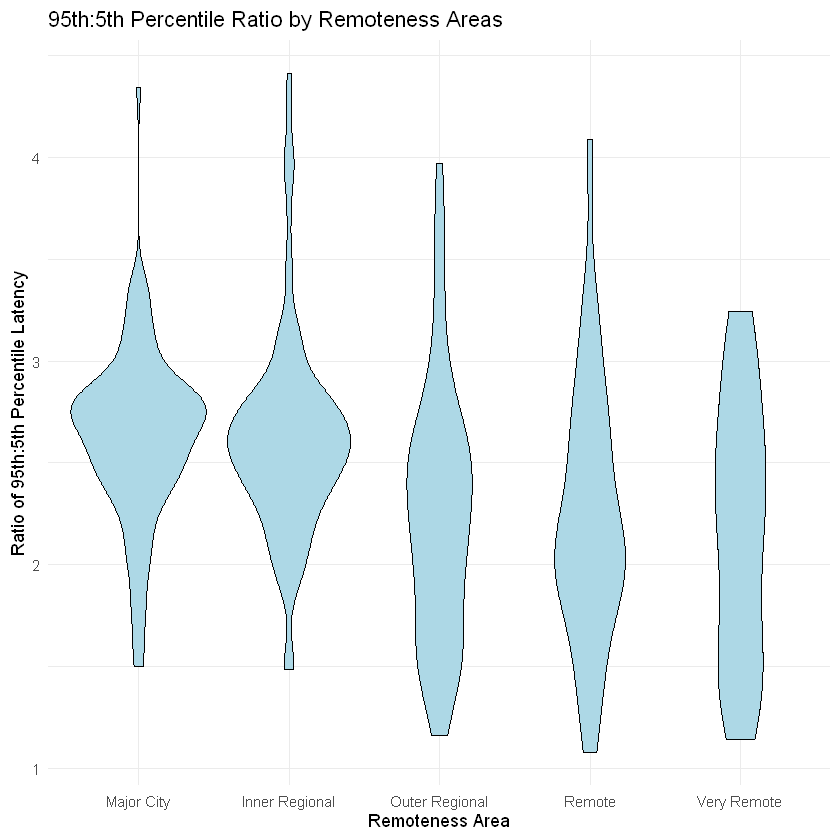

In [4]:
cleaned_data$Remoteness <- ifelse(cleaned_data$Major.City == 1, "Major City", ifelse(cleaned_data$Inner.Regional == 1, "Inner Regional", ifelse(cleaned_data$Outer.Regional == 1, "Outer Regional", ifelse(cleaned_data$Remote == 1, "Remote", "Very Remote"))))
cleaned_data$Remoteness <- factor(cleaned_data$Remoteness, levels = c("Major City", "Inner Regional", "Outer Regional", "Remote", "Very Remote"))

# Create the violin plot and assign it to variable 'p'
ggplot(cleaned_data, aes(x = Remoteness, y = X95th.5th.Ratio)) +
  geom_violin(fill = "lightblue", color = "black") +
  labs(x = "Remoteness Area", y = "Ratio of 95th:5th Percentile Latency",
       title = "95th:5th Percentile Ratio by Remoteness Areas") +
  theme_minimal()

# Create a data frame to store results of t-tests
results_table <- data.frame(Remoteness_Area_1 = character(), 
                             Remoteness_Area_2 = character(), 
                             Mean_1 = numeric(), 
                             Mean_2 = numeric(),
                             p_value = numeric(), 
                             Difference = numeric(), 
                             stringsAsFactors = FALSE)

# Perform t-tests between each pair of remoteness levels
remoteness_levels <- levels(cleaned_data$Remoteness)

for (i in 1:(length(remoteness_levels) - 1)) {
  for (j in (i + 1):length(remoteness_levels)) {
    test <- t.test(X95th.5th.Ratio ~ Remoteness, 
                   data = cleaned_data[cleaned_data$Remoteness %in% c(remoteness_levels[i], remoteness_levels[j]), ])
    
    # Calculate means
    mean_1 <- mean(cleaned_data$X95th.5th.Ratio[cleaned_data$Remoteness == remoteness_levels[i]], na.rm = TRUE)
    mean_2 <- mean(cleaned_data$X95th.5th.Ratio[cleaned_data$Remoteness == remoteness_levels[j]], na.rm = TRUE)
    
    # Add results to the data frame
    results_table <- rbind(results_table, 
                            data.frame(Remoteness_Area_1 = remoteness_levels[i], 
                                       Remoteness_Area_2 = remoteness_levels[j], 
                                       Mean_1 = mean_1, Mean_2 = mean_2,
                                       p_value = format(test$p.value, nsmall = 5),
                                       Difference = mean_2 - mean_1))
  }
}

# Print the results table
print(results_table)

## Begin Fitting

In [5]:
urban_data <- cleaned_data[(cleaned_data$Major.City == 1) | (cleaned_data$Inner.Regional == 1), ]
rural_data <- cleaned_data[(cleaned_data$Major.City == 0) & (cleaned_data$Inner.Regional == 0), ]

In [6]:
cor_matrix <- cor(cleaned_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")
#cor_matrix

#write.csv(cor_matrix, file = "correlation_matrix.csv", row.names = FALSE)

urban_cor_matrix <- cor(urban_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(urban_cor_matrix, file = "urban_correlation_matrix.csv", row.names = FALSE)

# rural correlation matrix
rural_cor_matrix <- cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(rural_cor_matrix, file = "rural_correlation_matrix.csv", row.names = FALSE)


Warning message in cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile", :
"the standard deviation is zero"


In [7]:
# Define a function for min-max normalization
min_max_normalize <- function(x) {
  (x - min(x)) / (max(x) - min(x))
}

# Normalize cleaned_data
cleaned_normalized <- as.data.frame(lapply(cleaned_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                              'closest_capital_distance', 'Population', 'Population.Density', 
                                                              'Population.Change..', 'Indigenous.Population..', 'Swing', 
                                                              'Seat.Change', 'is.Safe', 'is.Marginal', 'Remained.Marginal')], 
                                           min_max_normalize))

# Add the unscaled percentile columns back in (same filtering)
cleaned_normalized$X5th.Percentile <- cleaned_data$X5th.Percentile
cleaned_normalized$X50th.Percentile <- cleaned_data$X50th.Percentile
cleaned_normalized$X95th.Percentile <- cleaned_data$X95th.Percentile
cleaned_normalized$X95th.5th.Ratio <- cleaned_data$X95th.5th.Ratio

# Normalize urban_data
urban_normalized <- as.data.frame(lapply(urban_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                          'closest_capital_distance', 'Population', 'Population.Density', 
                                                          'Population.Change..', 'Indigenous.Population..', 'Swing', 
                                                          'Seat.Change', 'is.Safe', 'is.Marginal', 'Remained.Marginal')], 
                                         min_max_normalize))

# Add the unscaled percentile columns back in
urban_normalized$X5th.Percentile <- urban_data$X5th.Percentile
urban_normalized$X50th.Percentile <- urban_data$X50th.Percentile
urban_normalized$X95th.Percentile <- urban_data$X95th.Percentile
urban_normalized$X95th.5th.Ratio <- urban_data$X95th.5th.Ratio

# Normalize rural_data
rural_normalized <- as.data.frame(lapply(rural_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                          'closest_capital_distance', 'Population', 'Population.Density', 
                                                          'Population.Change..', 'Indigenous.Population..', 'Swing', 
                                                          'Seat.Change', 'is.Safe', 'is.Marginal', 'Remained.Marginal')], 
                                         min_max_normalize))

# Add the unscaled percentile columns back in
rural_normalized$X5th.Percentile <- rural_data$X5th.Percentile
rural_normalized$X50th.Percentile <- rural_data$X50th.Percentile
rural_normalized$X95th.Percentile <- rural_data$X95th.Percentile
rural_normalized$X95th.5th.Ratio <- rural_data$X95th.5th.Ratio


In [9]:
fit <- lm(cleaned_normalized$X95th.Percentile ~ IRSAD.Decile +
            Gini.Coefficient + Area..Km.2. +  
            closest_capital_distance + Population + Population.Density + 
            + Population.Change.. + Indigenous.Population.. +
            Swing + is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_normalized)

## AIC

In [10]:
# Fit the model with stepwise AIC selection
fit_aic <- step(fit)
summary(fit_aic)

Start:  AIC=3664.48
cleaned_normalized$X95th.Percentile ~ IRSAD.Decile + Gini.Coefficient + 
    Area..Km.2. + closest_capital_distance + Population + Population.Density + 
    +Population.Change.. + Indigenous.Population.. + Swing + 
    is.Safe + is.Marginal + Remained.Marginal

                           Df Sum of Sq     RSS    AIC
- IRSAD.Decile              1       192 3497405 3662.5
- Swing                     1       536 3497748 3662.5
- Area..Km.2.               1       870 3498083 3662.6
- Population                1      1598 3498811 3662.7
- is.Marginal               1      3786 3500999 3662.9
- closest_capital_distance  1      3872 3501084 3662.9
- Remained.Marginal         1      6365 3503578 3663.2
- is.Safe                   1     10840 3508052 3663.7
- Population.Density        1     14380 3511592 3664.1
<none>                                  3497212 3664.5
- Population.Change..       1     25365 3522578 3665.4
- Gini.Coefficient          1     29185 3526398 3665.8
- I


Call:
lm(formula = cleaned_normalized$X95th.Percentile ~ Gini.Coefficient + 
    Population.Change.. + Indigenous.Population.., data = cleaned_normalized)

Residuals:
    Min      1Q  Median      3Q     Max 
-232.60  -40.00   -9.43   17.30  560.38 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)               409.54      25.47  16.077  < 2e-16 ***
Gini.Coefficient           65.01      41.12   1.581  0.11474    
Population.Change..        83.84      43.74   1.917  0.05597 .  
Indigenous.Population..   -88.73      32.56  -2.725  0.00672 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 94.47 on 397 degrees of freedom
Multiple R-squared:  0.03921,	Adjusted R-squared:  0.03195 
F-statistic: 5.401 on 3 and 397 DF,  p-value: 0.001189


## BIC

In [11]:
fit_bic <- step(fit, direction = "both", k = log(nrow(cleaned_data)))
summary(fit_bic)

Start:  AIC=3716.4
cleaned_normalized$X95th.Percentile ~ IRSAD.Decile + Gini.Coefficient + 
    Area..Km.2. + closest_capital_distance + Population + Population.Density + 
    +Population.Change.. + Indigenous.Population.. + Swing + 
    is.Safe + is.Marginal + Remained.Marginal

                           Df Sum of Sq     RSS    AIC
- IRSAD.Decile              1       192 3497405 3710.4
- Swing                     1       536 3497748 3710.5
- Area..Km.2.               1       870 3498083 3710.5
- Population                1      1598 3498811 3710.6
- is.Marginal               1      3786 3500999 3710.8
- closest_capital_distance  1      3872 3501084 3710.9
- Remained.Marginal         1      6365 3503578 3711.1
- is.Safe                   1     10840 3508052 3711.6
- Population.Density        1     14380 3511592 3712.1
- Population.Change..       1     25365 3522578 3713.3
- Gini.Coefficient          1     29185 3526398 3713.7
- Indigenous.Population..   1     46208 3543420 3715.7
<non


Call:
lm(formula = cleaned_normalized$X95th.Percentile ~ Indigenous.Population.., 
    data = cleaned_normalized)

Residuals:
    Min      1Q  Median      3Q     Max 
-229.50  -41.20   -8.82   13.68  557.61 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              463.034      5.436  85.179  < 2e-16 ***
Indigenous.Population.. -106.775     31.571  -3.382  0.00079 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 94.79 on 399 degrees of freedom
Multiple R-squared:  0.02787,	Adjusted R-squared:  0.02543 
F-statistic: 11.44 on 1 and 399 DF,  p-value: 0.0007904


In [13]:
summary(cleaned_normalized$Indigenous.Population..)
summary(urban_normalized$Indigenous.Population..)
summary(rural_normalized$Indigenous.Population..)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01558 0.03984 0.08466 0.08596 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05375 0.14888 0.21583 0.32773 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.03520 0.07715 0.14677 0.15831 1.00000 

## Ridge Regression

[1] 105.3322



Call:
glm(formula = formula, data = cleaned_normalized)

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               444.604     37.232  11.941   <2e-16 ***
IRSAD.Decile                7.343     23.601   0.311   0.7559    
Median.Income             -51.489     52.623  -0.978   0.3285    
Gini.Coefficient           64.846     46.700   1.389   0.1658    
Area..Km.2.                30.830     73.376   0.420   0.6746    
closest_capital_distance  -13.487     31.831  -0.424   0.6720    
Population                -34.336     67.643  -0.508   0.6120    
Population.Density        -38.560     42.483  -0.908   0.3646    
Population.Change..        75.044     46.357   1.619   0.1063    
Indigenous.Population..  -103.568     45.105  -2.296   0.0222 *  
Swing                      -9.148     26.527  -0.345   0.7304    
is.Safe                   -14.611     13.051  -1.120   0.2636    
is.Marginal                -8.006     15.371  -0.521   0.6028    
Rema

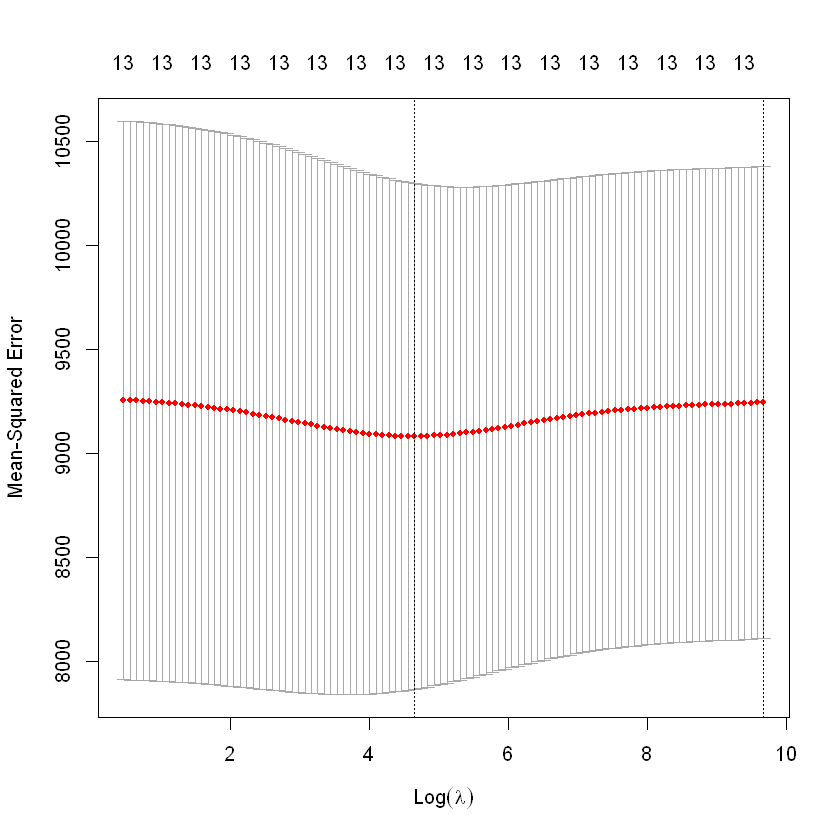

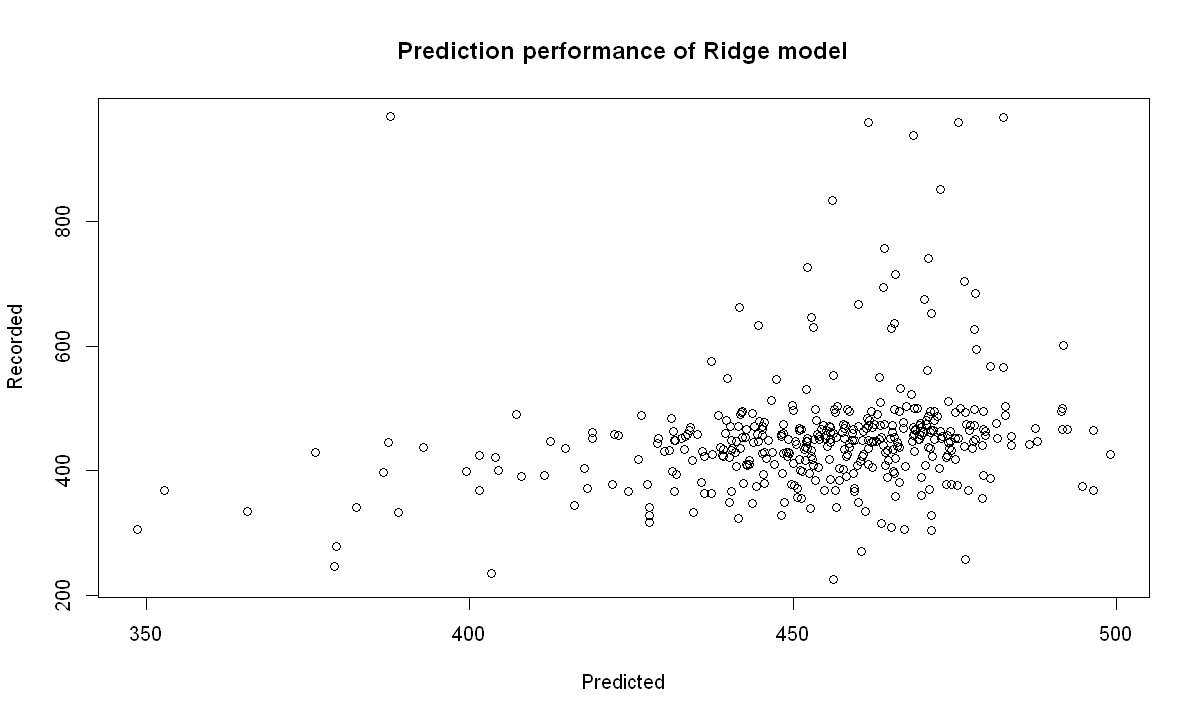

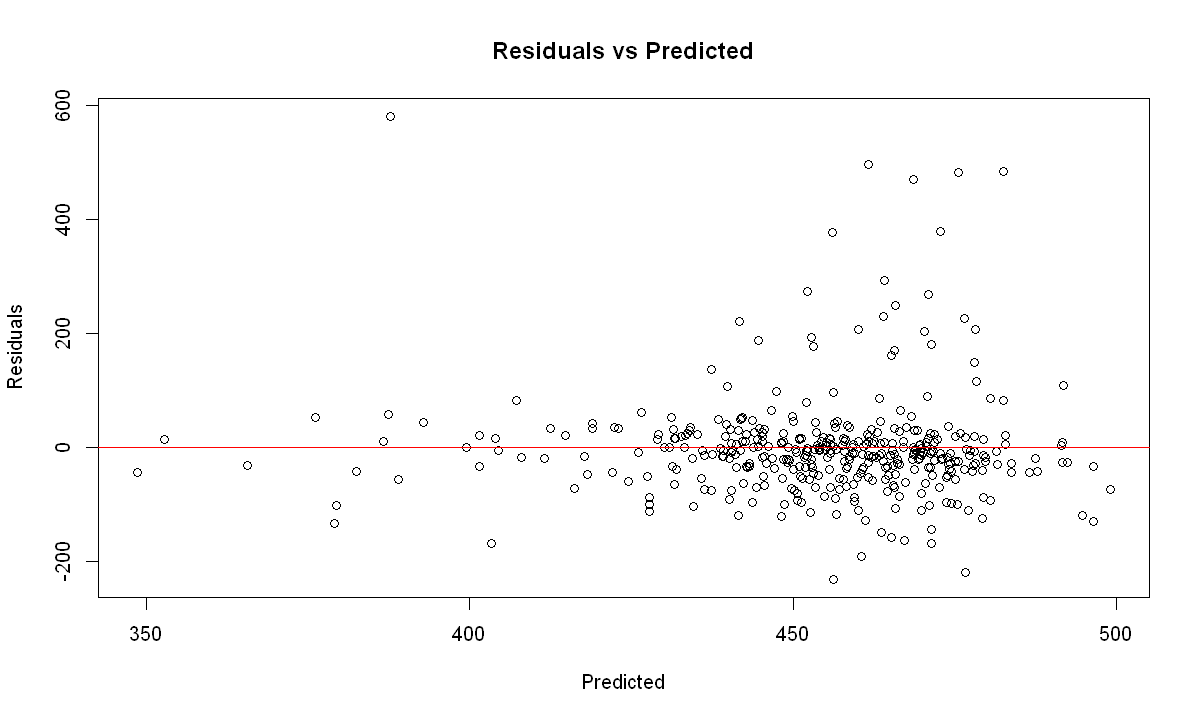

In [14]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(cleaned_normalized$X95th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_normalized)

y <- cleaned_normalized$X95th.Percentile

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = 0)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = 0, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.Percentile ~", paste(selected_vars, collapse = " + ")))
ridge_model <- glm(formula, data = cleaned_normalized)
summary(ridge_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(ridge_model, cleaned_normalized), cleaned_normalized$X95th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(ridge_model$fitted.values, resid(ridge_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## Lasso Regression

[1] 8.347399



Call:
glm(formula = formula, data = cleaned_normalized)

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)               434.84      19.85  21.902  < 2e-16 ***
Population.Change..        61.09      41.38   1.476  0.14066    
Indigenous.Population..   -97.49      32.14  -3.033  0.00258 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 8958.703)

    Null deviance: 3687867  on 400  degrees of freedom
Residual deviance: 3565564  on 398  degrees of freedom
AIC: 4792.2

Number of Fisher Scoring iterations: 2


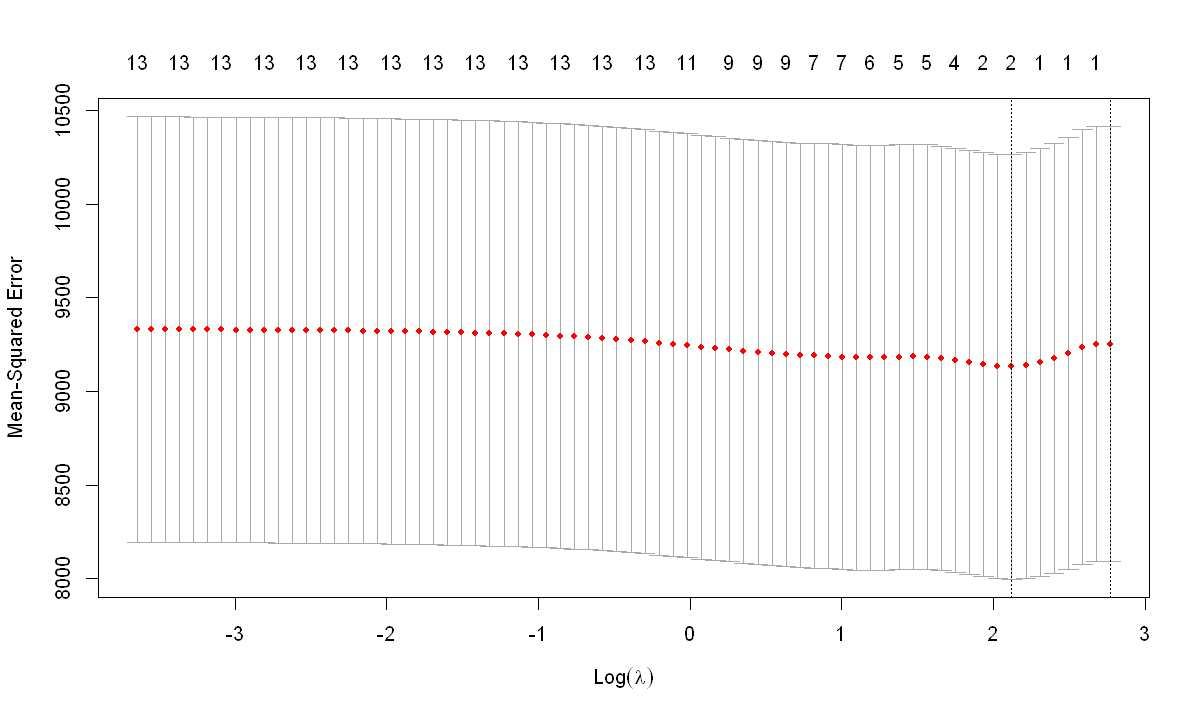

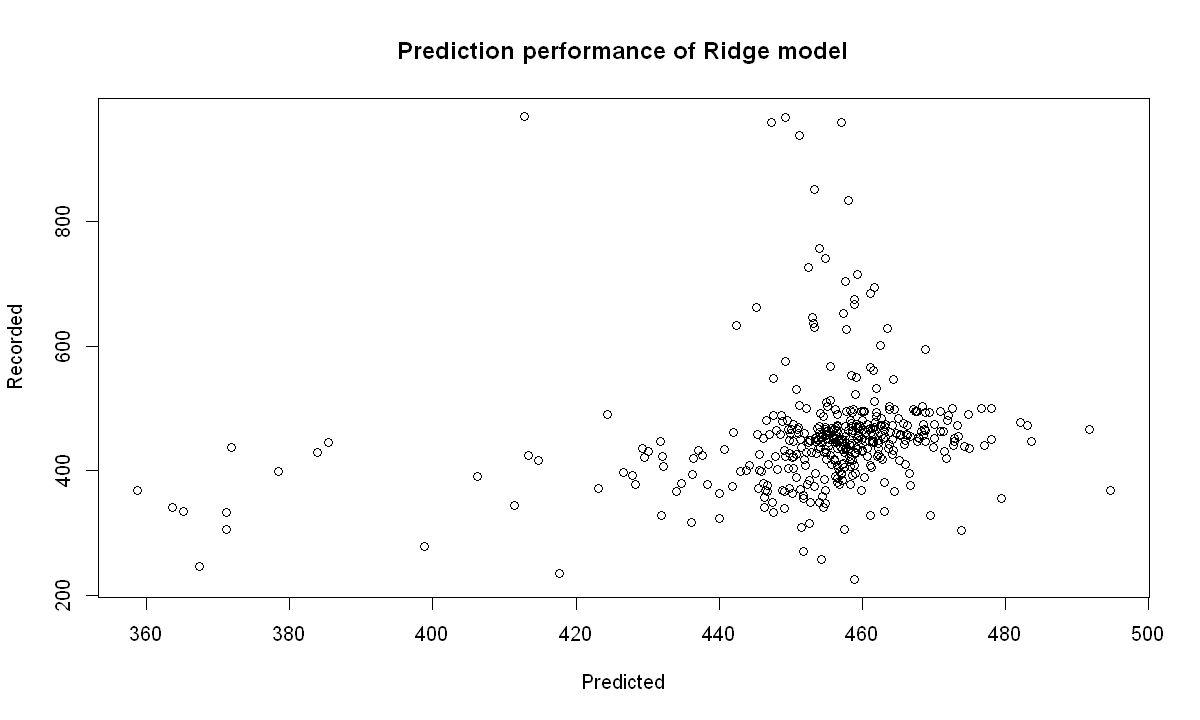

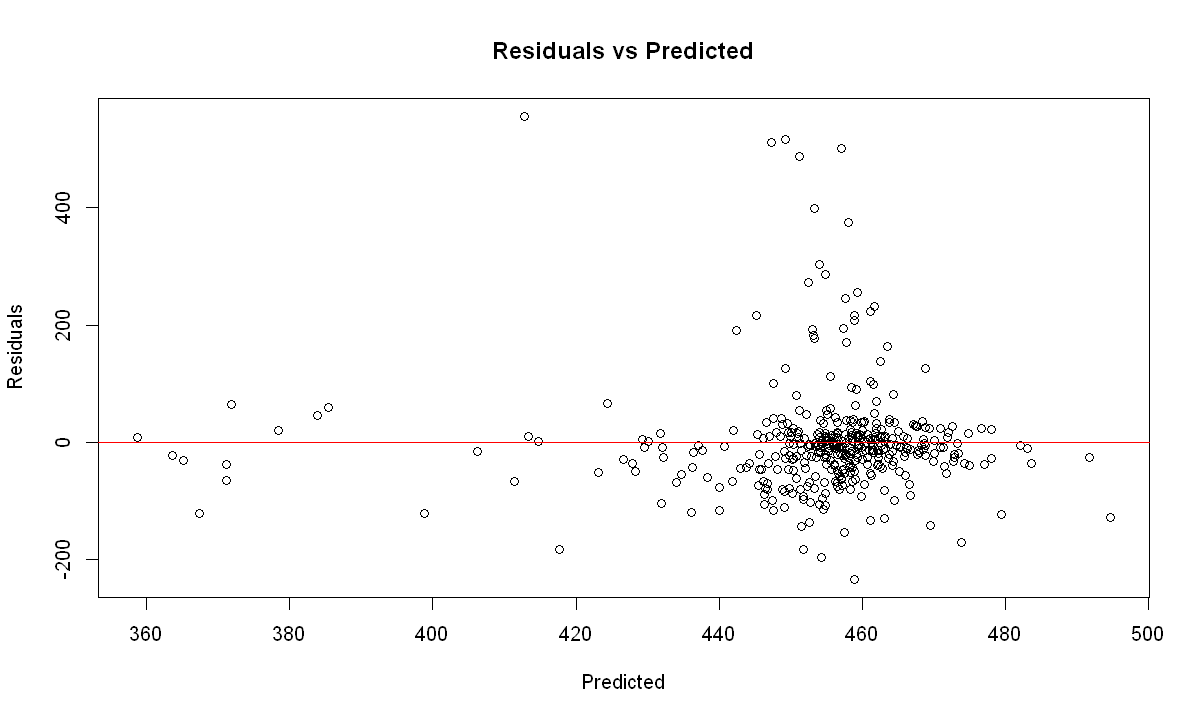

In [15]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(cleaned_normalized$X95th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_normalized)

y <- cleaned_normalized$X95th.Percentile

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = 1)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = 1, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]
if (length(selected_vars) == 0) {print('No variables selected')}

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.Percentile ~", paste(selected_vars, collapse = " + ")))
lasso_model <- glm(formula, data = cleaned_normalized)
summary(lasso_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(lasso_model, cleaned_normalized), cleaned_normalized$X95th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(lasso_model$fitted.values, resid(lasso_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## Elastic Net Regression

Best alpha: 0.4 
[1] 22.90315



Call:
glm(formula = formula, data = cleaned_normalized)

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               444.604     37.232  11.941   <2e-16 ***
IRSAD.Decile                7.343     23.601   0.311   0.7559    
Median.Income             -51.489     52.623  -0.978   0.3285    
Gini.Coefficient           64.846     46.700   1.389   0.1658    
Area..Km.2.                30.830     73.376   0.420   0.6746    
closest_capital_distance  -13.487     31.831  -0.424   0.6720    
Population                -34.336     67.643  -0.508   0.6120    
Population.Density        -38.560     42.483  -0.908   0.3646    
Population.Change..        75.044     46.357   1.619   0.1063    
Indigenous.Population..  -103.568     45.105  -2.296   0.0222 *  
Swing                      -9.148     26.527  -0.345   0.7304    
is.Safe                   -14.611     13.051  -1.120   0.2636    
is.Marginal                -8.006     15.371  -0.521   0.6028    
Rema

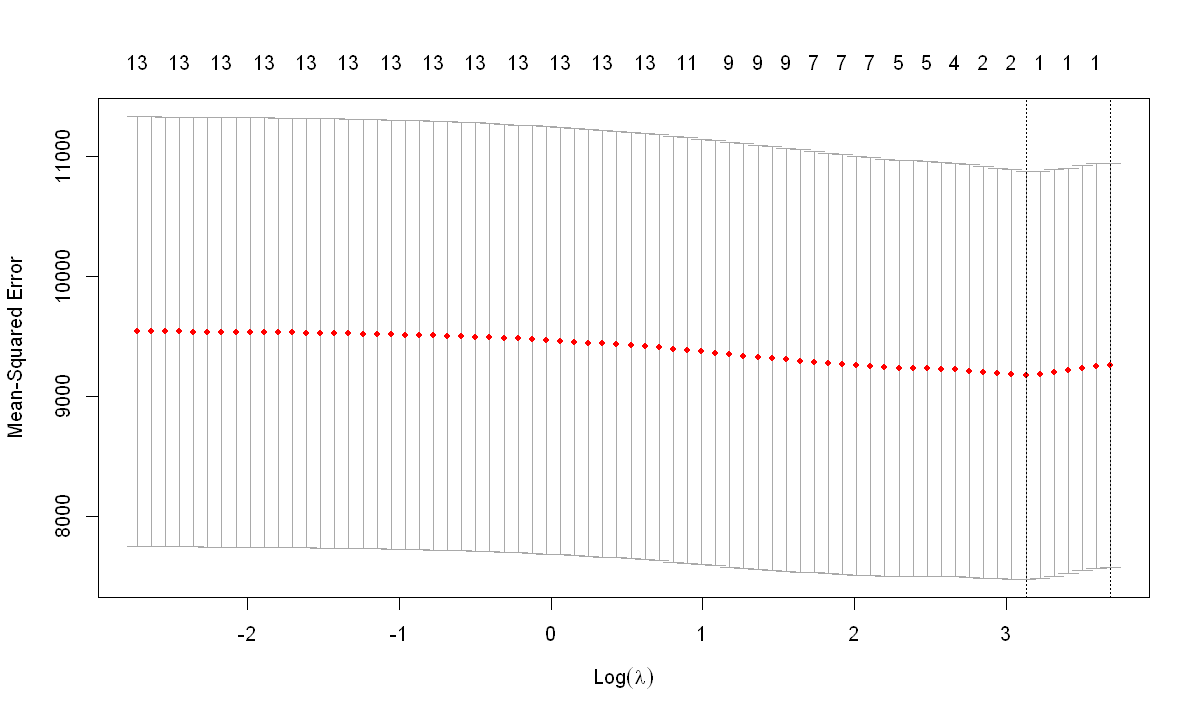

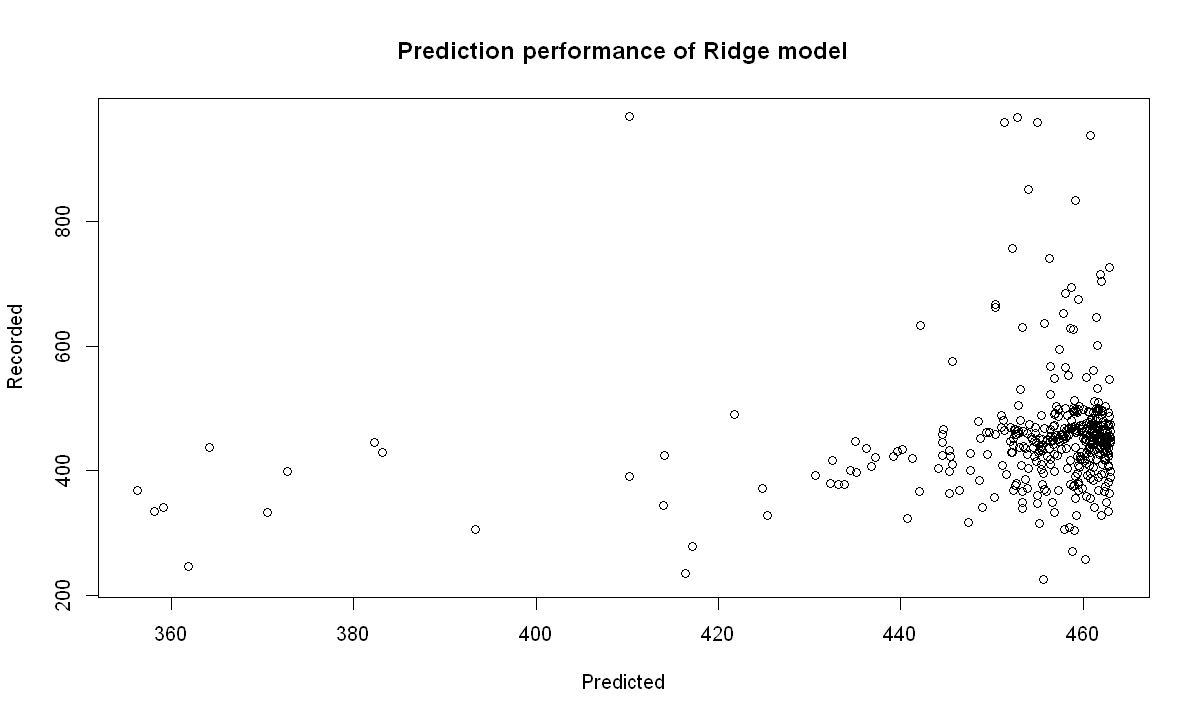

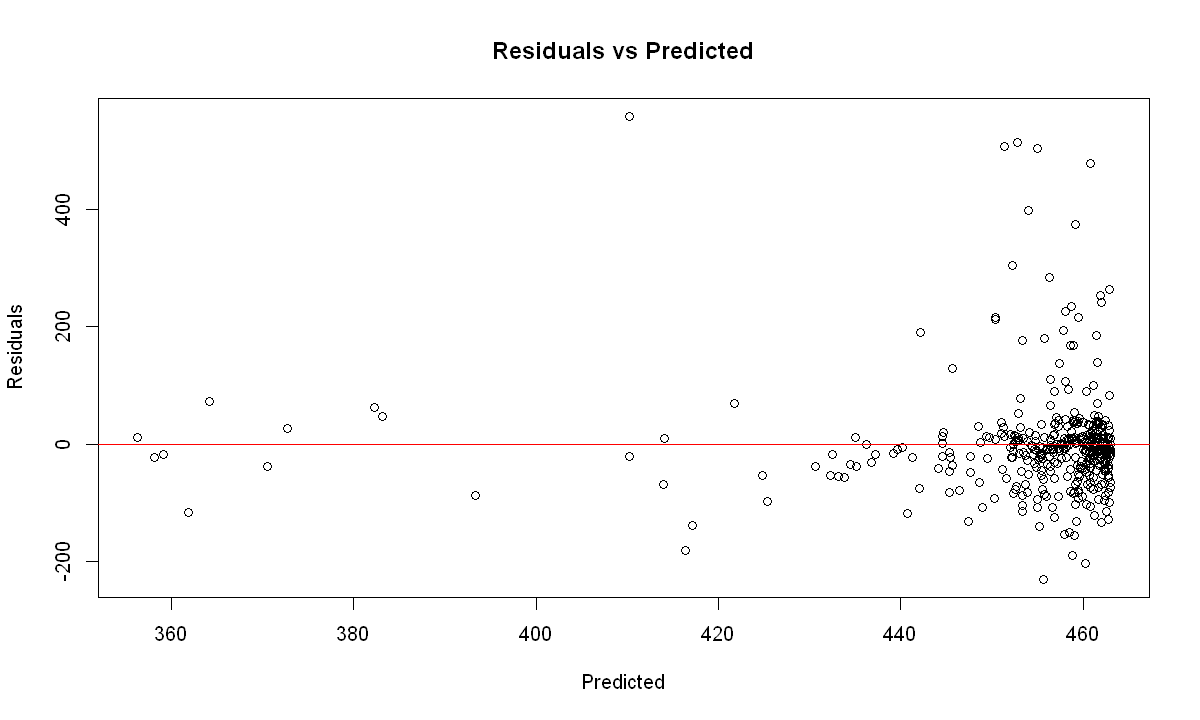

In [16]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(cleaned_normalized$X95th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_normalized)

y <- cleaned_normalized$X95th.Percentile

# Find the best alpha
best_alpha <- cv_alpha(x, y)
cat("Best alpha:", best_alpha, "\n")

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = best_alpha)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = best_alpha, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]
if (length(selected_vars) == 0) {print('No variables selected')}

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.Percentile ~", paste(selected_vars, collapse = " + ")))
elastic_model <- glm(formula, data = cleaned_normalized)
summary(ridge_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(elastic_model, cleaned_normalized), cleaned_normalized$X95th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(elastic_model$fitted.values, resid(elastic_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## idk, something else now

In [ ]:
ggplot(cleaned_scaled, aes(x = Median.Income, y = X95th.Percentile)) +
  geom_point(color = "blue") +
  labs(title = "Independent Variable vs Target Outcome", x = "Independent Variable", y = "Target Outcome") +
  theme_minimal()

In [ ]:
# Generate predicted values
cleaned_scaled$predicted_values <- predict(ridge_model, newdata = cleaned_scaled)

# Create a new column to classify urban and rural
cleaned_data$category <- ifelse(cleaned_data$Major.City == 1 | cleaned_data$Inner.Regional == 1, "Urban", "Rural")

# Create the plot
ggplot(cleaned_scaled, aes(x = predicted_values, y = X5th.Percentile, color = category)) +
  geom_point() +  # Actual data points
  geom_smooth(method = "lm", color = "blue", se = FALSE) +  # Linear regression line
  scale_color_manual(values = c("Urban" = "blue", "Rural" = "red")) +  # Set colors for categories
  labs(title = "95th Percentile", 
       x = "Fitted 95th Percentile [ms]", 
       y = "Actual 95th Percentile [ms]", 
       color = "Category") +  # Legend title
  theme_minimal() +
  xlim(min(cleaned_data$predicted_values), max(cleaned_data$predicted_values)) +  # Set x limits
  ylim(min(cleaned_data$X5th.Percentile), max(cleaned_data$X5th.Percentile))  # Set y limits


## All Hours vs Busy Hours

In [ ]:
# Create a data frame to store results
results <- data.frame(Variable = character(),
                      Comparison = character(),
                      p.value = numeric(),
                      stringsAsFactors = FALSE)

# List of pairs to compare
pairs <- list(
  c("X5th.Percentile", "Busy.5th.Percentile"),
  c("X50th.Percentile", "Busy.50th.Percentile"),
  c("X95th.Percentile", "Busy.95th.Percentile"),
  c("X95th.5th.Ratio", "Busy.95th.5th.Ratio")
)
pairs <- list(
  c("X5th.Percentile", "X5th.Percentile"),
  c("X50th.Percentile", "X50th.Percentile"),
  c("X95th.Percentile", "X95th.Percentile"),
  c("X95th.5th.Ratio", "X95th.5th.Ratio")
)

# Perform t-tests for each pair
for (pair in pairs) {
  var1 <- pair[1]
  var2 <- pair[2]
  
  # Perform t-test
  test <- t.test(urban_data[[var1]], rural_data[[var2]])
  
  # Store results
  results <- rbind(results, data.frame(Variable = var1,
                                        Comparison = var2,
                                        p.value = test$p.value))
}

# View results
print(results)


In [ ]:
summary(cleaned_data$X95th.5th.Ratio)
summary(cleaned_data$Busy.95th.5th.Ratio)

In [ ]:
# Set background color to white and text color to black
par(bg = "white", col.axis = "black", col.lab = "black", col.main = "black")

# Calculate the minimum and maximum from both datasets
minimum <- min(c(urban_data$X95th.5th.Ratio, rural_data$X95th.5th.Ratio))
maximum <- max(c(urban_data$X95th.5th.Ratio, rural_data$X95th.5th.Ratio))

# Define the breaks for intervals of 5
bin_size <- 0.1
breaks <- seq(floor(minimum / bin_size) * bin_size, ceiling(maximum / bin_size) * bin_size, by = bin_size)

# Create the histogram for urban data
hist(urban_data$X95th.5th.Ratio,
     breaks = breaks,
     main = "Frequency Histogram of 95th:5th Percentile Ratio (Urban vs. Rural)",
     xlab = "95th:5th Percentile Ratio Values",
     ylab = "Frequency",
     col = rgb(0, 0, 1, 0.5),  # Blue with transparency
     border = "black",
     xlim = c(minimum, maximum),  # Ensure x-axis covers the full range
     ylim = c(0, max(table(cut(urban_data$X95th.5th.Ratio, breaks)), 
                           table(cut(rural_data$X95th.5th.Ratio, breaks)))))  # Adjust y-axis limit

# Overlay the histogram for rural data
hist(rural_data$X95th.5th.Ratio,
     breaks = breaks,
     col = rgb(1, 0, 0, 0.5),  # Red with transparency
     border = "black",
     add = TRUE)  # Overlay this histogram


In [ ]:
apply(cleaned_data, 2, var)
nzv <- nearZeroVar(data, saveMetrics = TRUE)
nzv[nzv$zeroVar == TRUE, ]

In [ ]:
pca_result <- prcomp(cleaned_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Population", "Gini.Coefficient",
                            "Population.Change", "X..Population.Change", 
                            "Area..Km.2.", "Population.Density", 
                            "Indigenous.Population", 
                            "X..Indigenous.Population")], 
                            scale. = TRUE)  # Standardize data before PCA

# View the PCA summary to see the proportion of variance
summary(pca_result)

# Use the first few principal components that explain the most variance
pca_components <- pca_result$x[, 1:10]  # Replace 1:5 with desired slice

# Fit a new model using the principal components
pca_model <- lm(X95th.5th.Ratio ~ pca_components, data = cleaned_data)

# View the summary of the new model
summary(pca_model)

### visualise against certain significant variables

In [ ]:
ggplot(cleaned_scaled, aes(x = Area..Km.2., y = X5th.Percentile)) +
  geom_point(color = "blue") +
  labs(title = "Independent Variable vs Target Outcome", x = "Independent Variable", y = "Target Outcome") +
  theme_minimal()

In [ ]:
summary(cleaned_scaled$Area..Km.2.)

### perform and plot the predictions

In [ ]:
par(bg = "white")
predictions <- predict(fit, cleaned_data)
plot(predict(fit, cleaned_data), cleaned_data$X95th.Percentile)
#calculate mean squared error
mean((predictions - target_variable)^2)